# Card Sample: Template Matching for composite object detection

### Library Imports

In [1]:
import os
import sys
import numpy as np
from PIL import Image
from os.path import join
from collections import deque
from skimage.feature import hog
from skimage import data, exposure
from matplotlib.pyplot import imshow 
from matplotlib.pyplot import subplots
print("Successfully imported all standard modules!")

Successfully imported all standard modules!


### Project Imports

In [2]:
# append base project dir to sys path
sys.path.append(os.path.abspath(join(os.getcwd(), os.pardir, os.pardir)))
# project specific imports
from cascading_detector.serializable import Serializable
from cascading_detector.tools.typeconv import byte_to_pil
from cascading_detector.tools.imgutils import draw_bounding_box_on
from cascading_detector.method.templatematching.tmmodel import TMModel
from cascading_detector.method.templatematching.tmdetectable import TMDetectable
from cascading_detector.method.templatematching.templatematching import TemplateMatching
print("Successfully imported all project specific modules!")

Successfully imported all project specific modules!


### Set up directory paths

In [3]:
base_dir = join(os.getcwd(), "model")
input_dir = join(base_dir, "raw_input")
template_dir = join(base_dir, "raw_template")
export_dir = join(base_dir, "exported_template")

### Create and serialize Detectables

#### Configure a composite card object

In [4]:
# list all files
for file in os.listdir(template_dir):
    fname = os.path.join(template_dir, file)
    print(fname)

C:\dev\repos\engelmi\cascading_detector\notebooks\templatematching\model\raw_template\card_3.png
C:\dev\repos\engelmi\cascading_detector\notebooks\templatematching\model\raw_template\card_4.png
C:\dev\repos\engelmi\cascading_detector\notebooks\templatematching\model\raw_template\symbol_spade.png


In [5]:
card_3 = TMDetectable("card_3", Image.open(join(template_dir, "card_3.png")), threshold=0.75)
print(card_3)
symbol_spade = TMDetectable("symbol_spade", Image.open(join(template_dir, "symbol_spade.png")), threshold=0.8)
print(symbol_spade)

In [6]:
card_3.add_child(symbol_spade)
symbol_spade.set_parent(card_3)

In [7]:
card_3_spades_filename = join(export_dir, card_3.class_id)
card_3.write_to_file(card_3_spades_filename, True)
print("Successfully exported detectable for card with number 4 and spades!")

Successfully exported detectable for card with number 4 and spades!


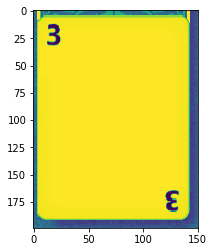

In [8]:
c3 = Serializable.read_from_file(card_3_spades_filename)
reconstructed_template_image = byte_to_pil(c3.template_image_bytes)
imshow(np.asarray(reconstructed_template_image))

#### Build and use a Template Matching Model

In [10]:
list_of_detectable_files = [card_3_spades_filename]
model = TMModel(list_of_detectable_files, load_type=TMModel.LoadType.EAGER)
tm = TemplateMatching(model)

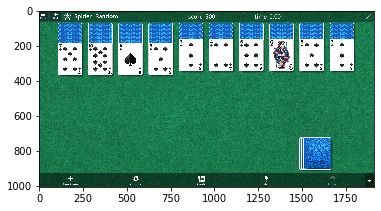

In [14]:
input_image_file = join(input_dir, "spider.png")
input_image = Image.open(input_image_file)
detection_dict = tm.detect_objects_in_pil_image(input_image)
imshow(np.asarray(input_image))

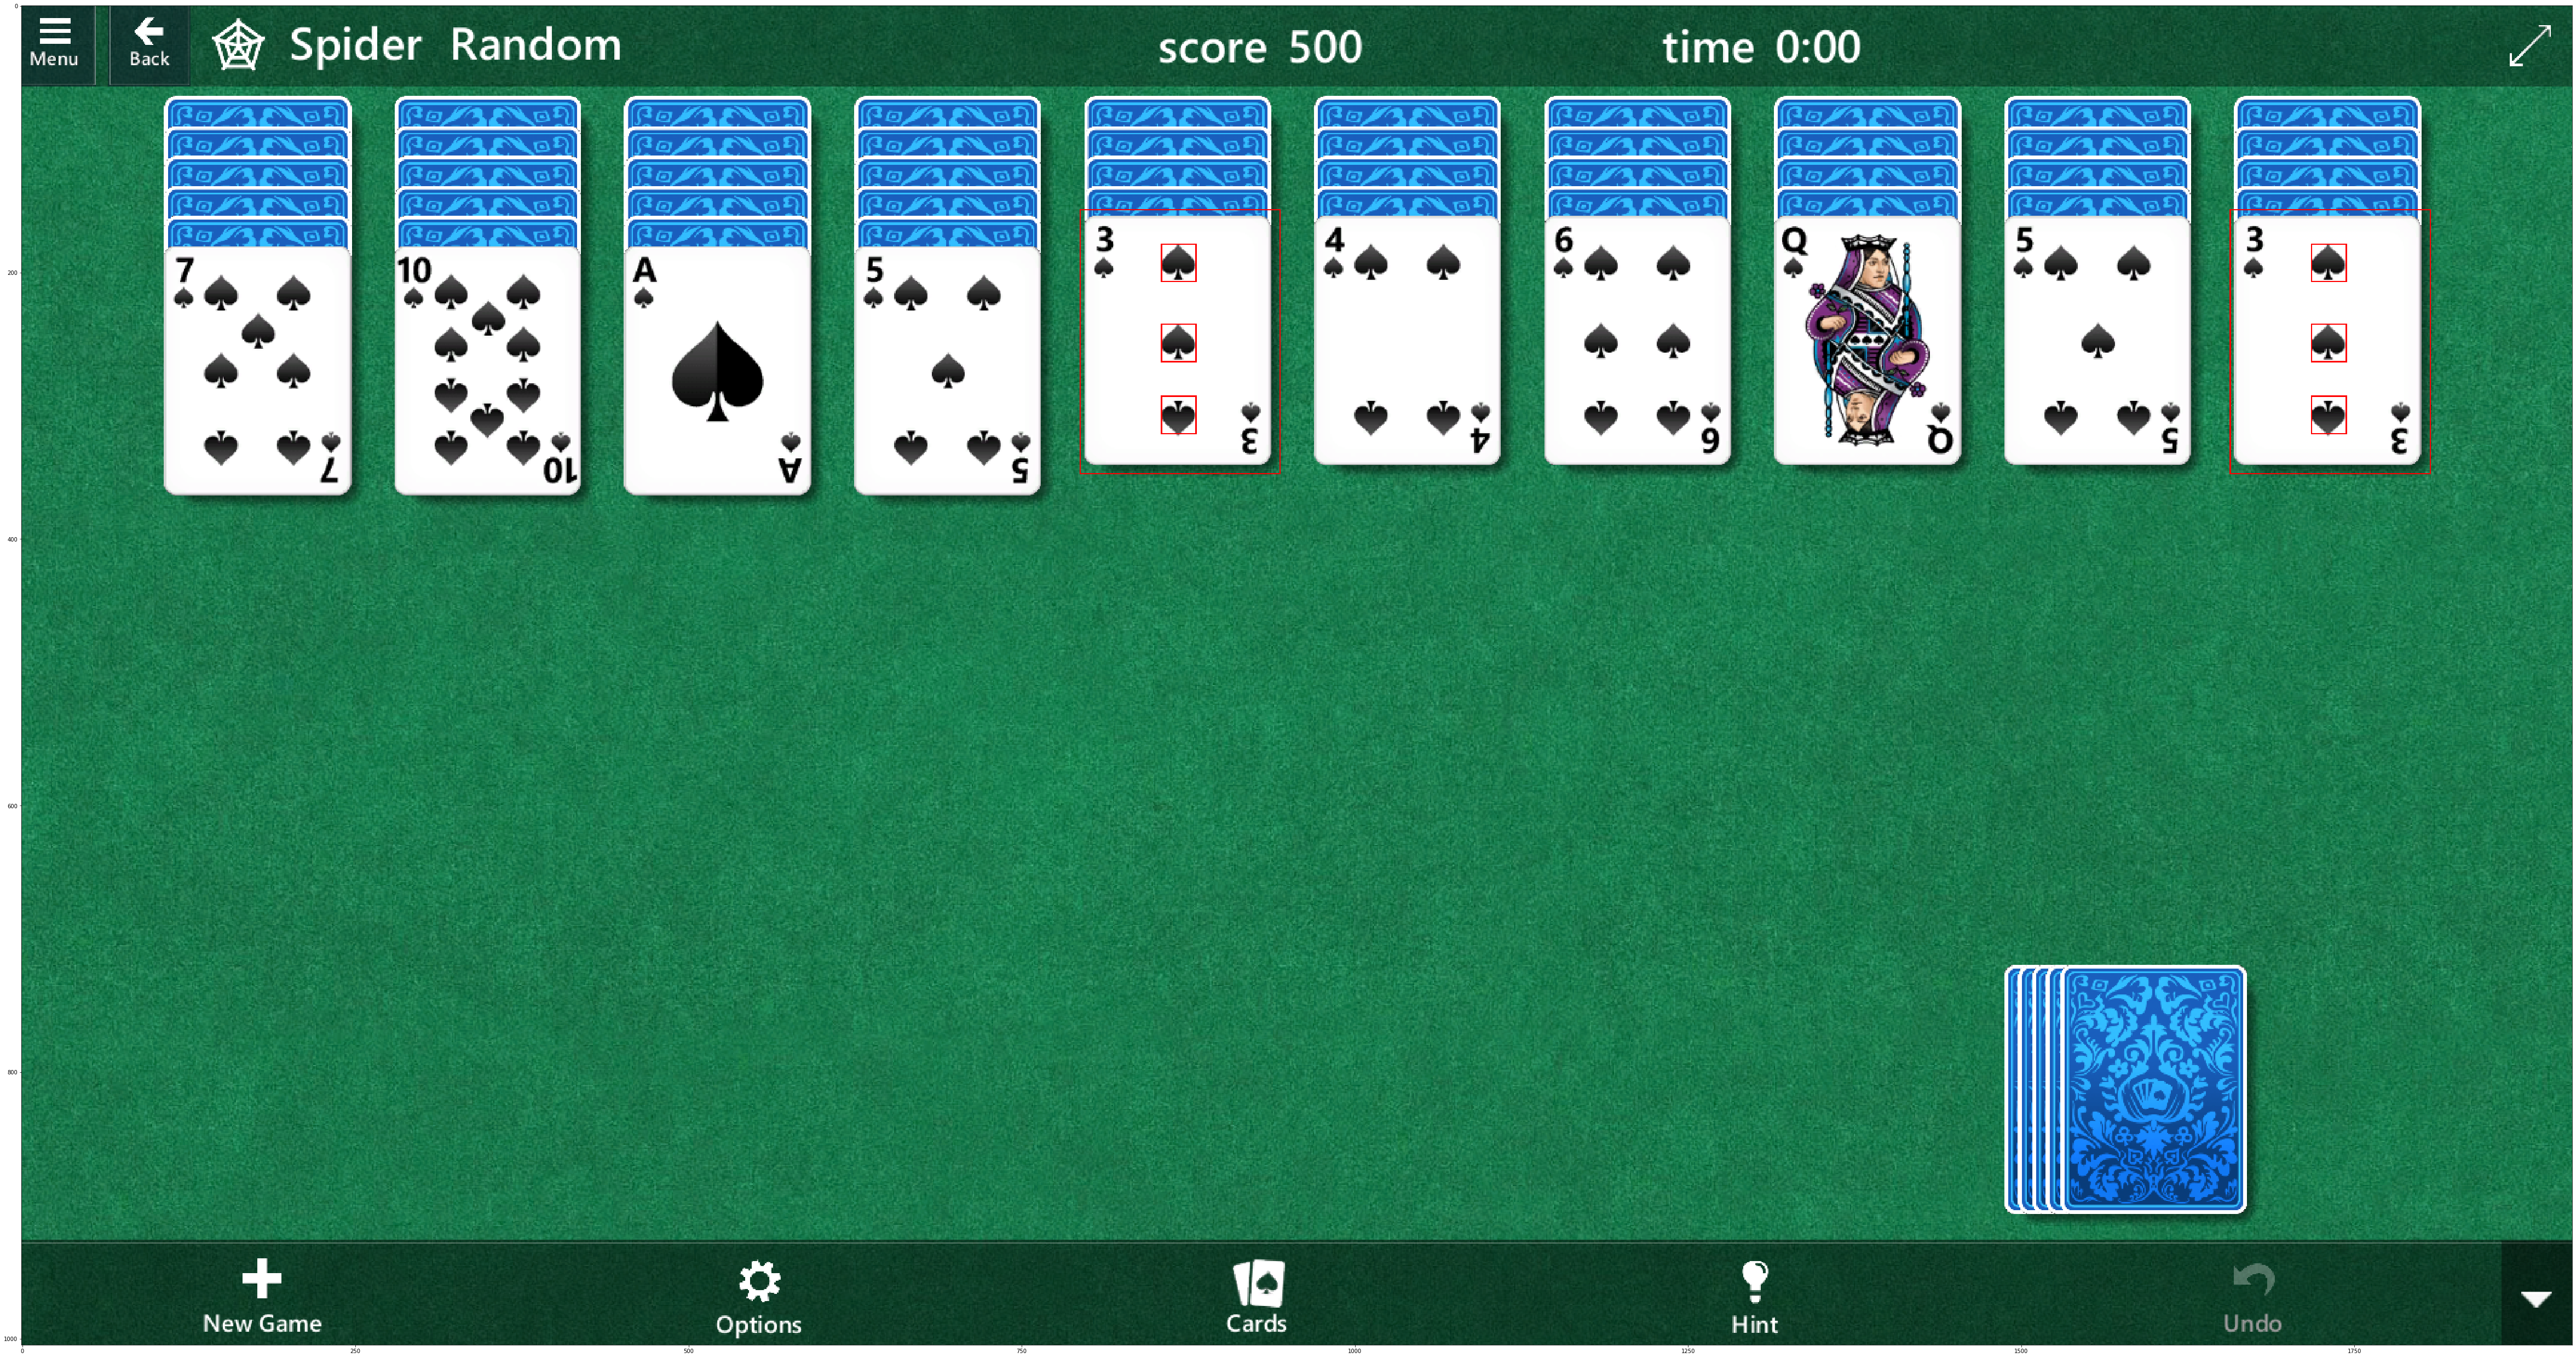

In [17]:
for cls, base_detection in detection_dict.items():
    to_explore = deque()
    to_explore.append(base_detection)
    while to_explore:
        curr = to_explore.popleft()
        for sub_detection in curr.sub_detection_list:
            to_explore.append(sub_detection)
            draw_bounding_box_on(input_image, sub_detection.bounding_box)
#input_image.show()
_, ax = subplots(figsize=(90,45))
ax.imshow(np.asarray(input_image))

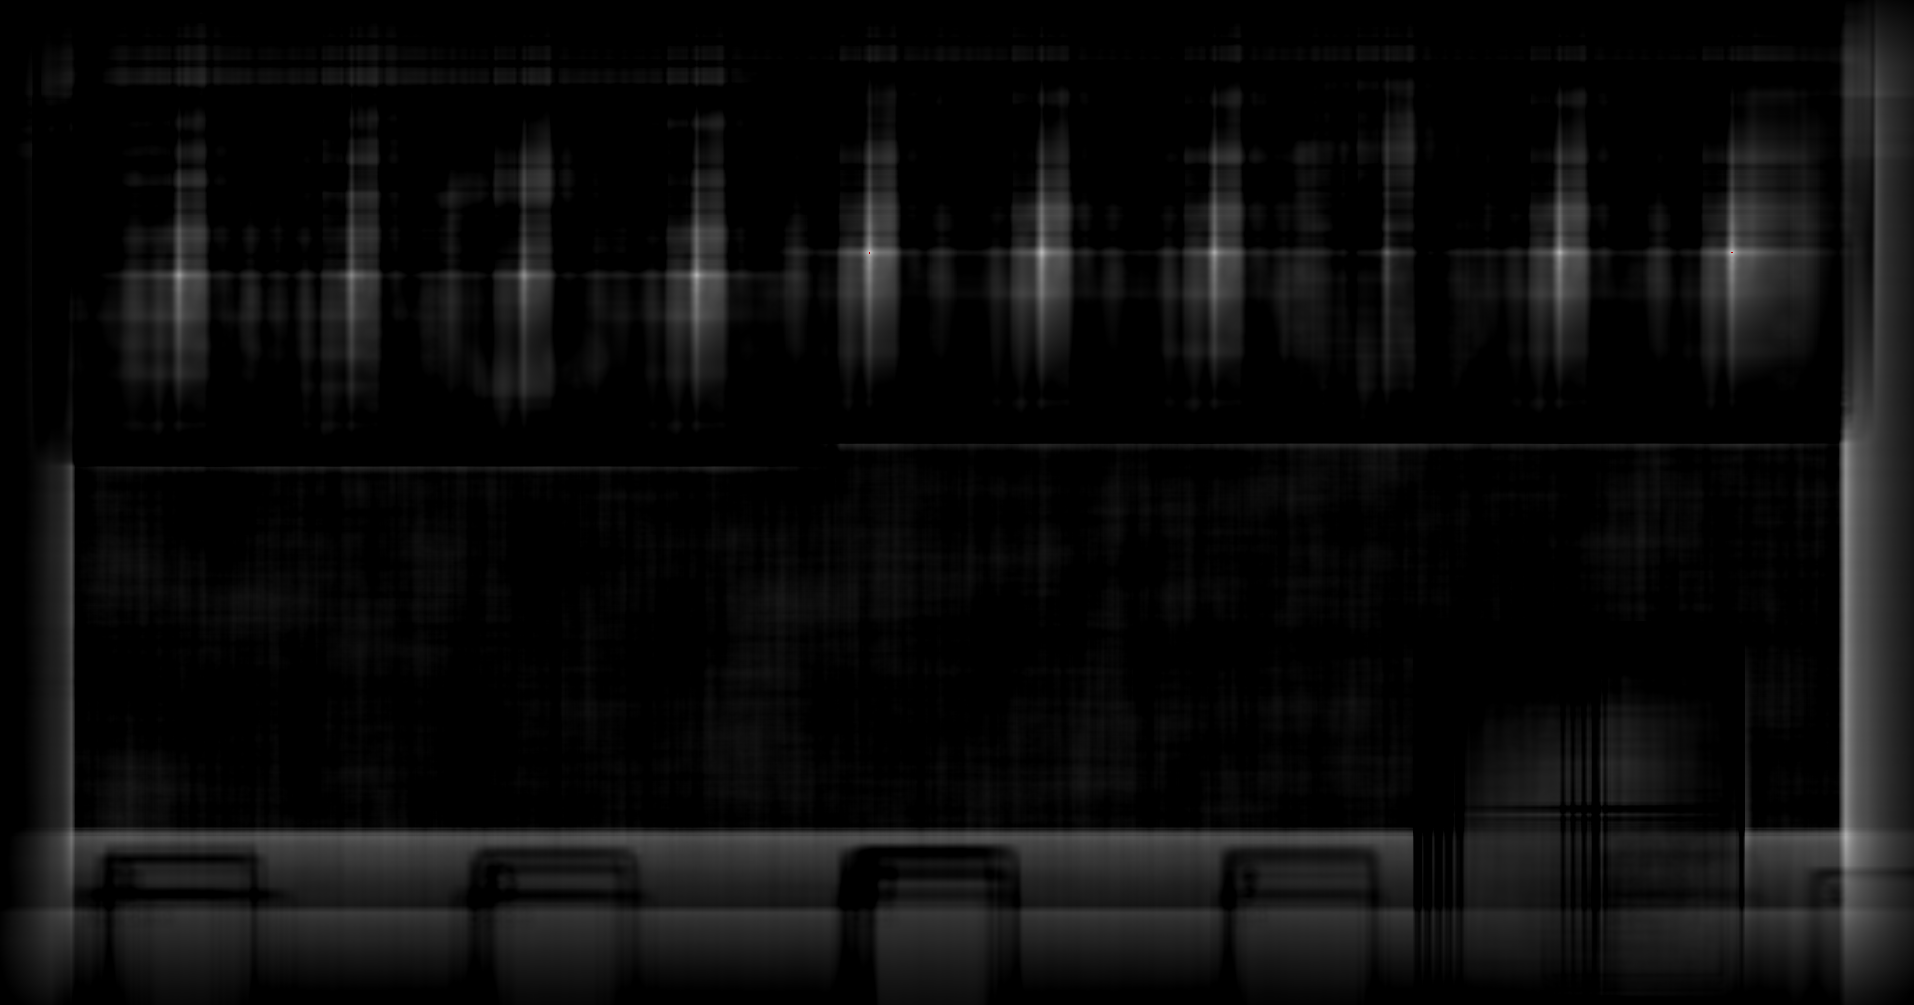

In [21]:
input_image_arr = np.asarray(input_image.convert("L"))
template_arr = np.asarray(
    byte_to_pil(model.detectables[card_3_spades_filename].template_image_bytes)
)
tm.generate_heatmap(input_image_arr, template_arr, 0.75)